In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import random
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from func import *

# inline plot
%matplotlib inline

In [2]:
#%load 'data/raw-twt2016-01-26-14/21/09.csv'
df = pd.read_csv("data/raw-twt2016-01-26-14-21-09.csv",sep='\t',error_bad_lines=False)
# df.head(5)
print len(df.index)
list(df.columns.values)

3199


['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions']

Cleanin' the data

In [3]:
# Fill in blank hashtags
df = df.where((pd.notnull(df)), np.nan)
df["hashtags"].fillna('')

# Add some date/time things
df["created_at"] = pd.to_datetime(df["created_at"], errors='coerce')
df["day_of_week"] = df["created_at"].apply(lambda x: x.weekday())
df["day_of_month"] = df["created_at"].apply(lambda x: x.day)
df["month"] = df["created_at"].apply(lambda x: x.month)
df["time_of_day"] = df["created_at"].apply(lambda x: get_time_of_day(x))
# df['in_reply_to_screen_name'].fillna(-1)
# df['in_reply_to_status_id'].fillna(-1)
# df['in_reply_to_user_id'].fillna(-1)
# df['retweeted_status'].fillna(-1)
# df['retweeted'].fillna(-1)
df['retweet_count'].fillna(np.nan)
df['favorite_count'].fillna(np.nan)
df["hashtags"].fillna(np.nan)
df["hashtags"] = df["hashtags"].apply(lambda x: str(x)[1:-1])
df.loc[df["hashtags"]=='a',"hashtags"] = ''
list(df.columns.values)

['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day']

In [4]:
#Potentially remove, just cleaning for analysis sake
del df['Unnamed: 0']
del df['truncated']
del df['user_mentions']
del df['urls']
del df['source']
del df['lang']
del df['place']
del df['favorited']
del df['media']
del df['user']

# More likely to remove
del df['in_reply_to_status_id']
del df['in_reply_to_user_id']
del df['retweeted']
del df['retweeted_status']

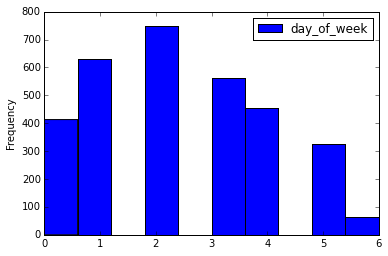

In [5]:
df.plot(x='created_at', y='day_of_week', kind='hist')
# fdf = df[["created_at","id","text","hashtags"]]
# str(fdf

Let's start getting some more detailed data from the trips as well

In [6]:
# df['favorite_count'] = df['favorite_count'].astype(np.int64)
# df['retweet_count'] = df['retweet_count'].astype(np.int64)
# df['text'] = df['text'].astype(str)
# df['id'] = df['id'].astype(np.int64)
# df['day_of_week'] = df['day_of_week'].astype(np.int64)
# df['day_of_month'] = df['day_of_month'].astype(np.int64)
# df['month'] = df['month'].astype(np.int64)
# df['time_of_day'] = df['time_of_day'].astype(np.int64)
df.loc[df["hashtags"]=='on',"hashtags"] = np.nan
df.convert_objects(convert_numeric=True)
df.dtypes

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


created_at                 datetime64[ns]
favorite_count                    float64
hashtags                           object
id                                  int64
in_reply_to_screen_name            object
retweet_count                     float64
text                               object
day_of_week                         int64
day_of_month                        int64
month                               int64
time_of_day                         int64
dtype: object

In [50]:
# Pull out potential trains from both hashtags and text
df["topic_train"] = df["text"].apply(lambda x: check_hashtag(x))
df["topic_train"] = df["topic_train"].apply(lambda x: str(x)[1:-1])
df["topic_train"].fillna(np.nan)
df.head(5)

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,month,time_of_day,topic_train
0,2016-01-26 20:32:15,6,SanFrancisco,692082643022680064,NaN,7,NOTICE: Ped &amp; Bike detours in place for Ma...,1,26,1,0,
1,2016-01-26 19:41:32,NaN,,692069881559134208,therealwall,NaN,@therealwall After the end of the concert we w...,1,26,1,3,
2,2016-01-26 19:28:52,NaN,SB50,692066695838498816,AemalTheAFGHAN,NaN,@AemalTheAFGHAN @BKDenverSports We're glad to ...,1,26,1,3,'50'
3,2016-01-26 18:12:35,1,"Sorry, Headphones",692047497238175744,4c4d,NaN,"@4c4d Oh man. We love that, too. Our favorite ...",1,26,1,3,
4,2016-01-26 17:53:20,7,,692042650933862401,NaN,18,"Pssst, hey, regular Caltrain riders: expect a ...",1,26,1,3,


In [9]:
# pd.pivot_table(
#   df,values='values',
#   index=['month'],
#   columns=['day_of_week'])

First, a word about the below code.
In the accompanying `func.py` there is a function called parse_train that returns a `pandas.Series` object. For some reason, when it's returned from a map or apply, it seems to get cast as a string. When applied to a list or a dataframe, this string gets turned into a single field in the row, OR divided into several rows, throwing the count off.

To get around this, I return the results of the parse_train function and then CAST it back to a series. This adds a weird 0 index, which I delete. I then fill in the plethora of NaNs and recombine it with the primary dataframe.

For context, previous iterations included
`df['topic_train'].apply(lambda x:parse_train(x))`
which would return a pd.Series object with `str` versions of the returned pd.Series from `parse_train`

In [102]:
ret = []

def parse_train(t):
# x should be a list with train codes eg 123
# {"id": "123", "type:" "bullet", direction: "south"}

    try:
        s = t['topic_train'].split(',')
    except:
        return t['topic_train']
    if s[0] == '':
#         print ""
        return np.nan
    for x in s:
#         print "Iter",x[1:-1]
        q = {}
        # Check train id
        x = str(x[1:-1])
        if len(x)<3: continue

        # 1 = north, 2 = south
        q["direction"] = 1 if x[2] in [1,3,5,7,9] else 0

        if x[0] == '1':
            q["type"] = 0 # local
        elif x[0] == '2':
            q["type"] = 1 # limited
        elif x[0] == '3':
            q["type"] = 2 # bullet
        else:
            q["type"] = -1
        ret.append({'tweet_id': t['id'],'timestamp': t['created_at'], 'train_id':x, 'train_direction':q["direction"], 'train_type': q["type"] })
    return s

In [103]:
# Let's then filter those train topics into details
# Btw this is jank as fuck.

# red = df[['id','created_at','topic_train']]
red = df.apply(lambda x:parse_train(x),axis=1)
#red
ret
#events = pd.DataFrame([pd.Series(x) for x in red.apply(parse_train)])
#events
#del new.iloc[0]
#new.fillna('')
#df.combine_first(new)

[{'timestamp': Timestamp('2016-01-25 23:42:14'),
  'train_direction': 0,
  'train_id': '155',
  'train_type': 0,
  'tweet_id': 691768068385718275},
 {'timestamp': Timestamp('2016-01-20 22:22:55'),
  'train_direction': 0,
  'train_id': '151',
  'train_type': 0,
  'tweet_id': 689936168893329408},
 {'timestamp': Timestamp('2016-01-19 18:08:25'),
  'train_direction': 0,
  'train_id': '138',
  'train_type': 0,
  'tweet_id': 689509733640732672},
 {'timestamp': Timestamp('2016-01-19 16:32:04'),
  'train_direction': 0,
  'train_id': '216',
  'train_type': 1,
  'tweet_id': 689485484838416388},
 {'timestamp': Timestamp('2016-01-19 16:32:04'),
  'train_direction': 0,
  'train_id': "'225",
  'train_type': -1,
  'tweet_id': 689485484838416388},
 {'timestamp': Timestamp('2016-01-19 16:32:04'),
  'train_direction': 0,
  'train_id': "'329",
  'train_type': -1,
  'tweet_id': 689485484838416388},
 {'timestamp': Timestamp('2016-01-19 16:10:57'),
  'train_direction': 0,
  'train_id': '323',
  'train_type'

In [12]:
# pd.scatter_matrix(df,alpha=0.01,figsize=(15,15), diagonal='hist');


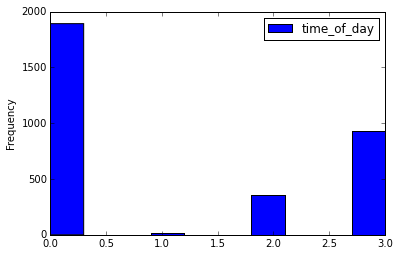

In [13]:
df.plot(x='day_of_week', y='time_of_day', kind='hist')

In [14]:
list(df.columns.values)

['created_at',
 'favorite_count',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'retweet_count',
 'text',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day',
 'topic_train']

In [15]:
rank_late(df.iloc[1])

AttributeError: 'Series' object has no attribute 'train_topic'